In [ ]:
!pip install hyperopt
!pip install xgboost

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import numpy as np

import pickle

import math

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import seaborn as sns

from scipy import interp
from itertools import cycle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib

import statsmodels.formula.api as smf

import xgboost
from xgboost import XGBClassifier

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

np.random.seed(42)

## 1. Load Data

In [2]:
df = pd.read_csv('dataset.csv')

ParserError: Error tokenizing data. C error: Expected 1 fields in line 8, saw 2


In [4]:
from csv import reader
N = 7
with open('dataset.csv') as f:
    print(next((x for i, x in enumerate(reader(f)) if i == N), None))

['29b7e418-f057-44fc-8d5c-50015b5a5856;0;0;0;142;0;0;1;2;2;1;3;49;3;3;"Concept stores & Miscellaneous";"Leisure', ' Sport & Hobby";TRUE;2373;2373;"L1+F";0;0;0;0;1;0;0;0;0;0;1;0;0;1;1;1;0;18760;8337;2373;10.2444444444444;NA']


In [ ]:
df = pd.read_csv('dataset.csv', error_bad_lines=False)

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
df.head()

In [5]:
i = 0
columns = []
dict_data = {}
with open("dataset.csv", "r") as ins:
    for line in ins:
        if i == 0:
            columns = line.split(';')
            for col in columns:
                dict_data[col] = []
        else:
            array = line.split(';')
            for j, el in enumerate(array):
                dict_data[columns[j]].append(el)
        i += 1

df = pd.DataFrame(dict_data)

In [6]:
df.head()

,"""account_amount_added_12_24m""","""account_days_in_dc_12_24m""","""account_days_in_rem_12_24m""","""account_days_in_term_12_24m""","""account_incoming_debt_vs_paid_0_24m""","""account_status""","""account_worst_status_0_3m""","""account_worst_status_12_24m""","""account_worst_status_3_6m""","""account_worst_status_6_12m""",...,"""status_last_archived_0_24m""","""status_max_archived_0_12_months""","""status_max_archived_0_24_months""","""status_max_archived_0_6_months""","""sum_capital_paid_account_0_12m""","""sum_capital_paid_account_12_24m""","""sum_paid_inv_0_12m""","""time_hours""","""uuid""","""worst_status_active_inv"""
0,0,0,0,0,0,1,1,NA,1,NA,...,1,1,1,1,0,0,178839,9.65333333333333,"""63f69b2c-8b1c-4740-b78d-52ed9a4515ac""",1\n
1,0,0,0,0,NA,1,1,1,1,1,...,1,2,2,1,0,0,49014,13.1813888888889,"""0e961183-8c15-4470-9a5e-07a1bd207661""",NA\n
2,0,0,0,0,NA,NA,NA,NA,NA,NA,...,1,2,2,1,0,0,124839,11.5619444444444,"""d8edaae6-4368-44e0-941e-8328f203e64e""",1\n
3,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,1,1,1,1,0,0,324676,15.7511111111111,"""0095dfb6-a886-4e2a-b056-15ef45fdb0ef""",1\n
4,0,0,0,0,NA,NA,NA,NA,NA,NA,...,1,1,1,1,0,0,7100,12.6986111111111,"""c8f8b835-5647-4506-bf15-49105d8af30b""",NA\n


## 2. EDA and Data Preparation

In [7]:
df.shape

(99976, 43)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
"account_amount_added_12_24m"            99976 non-null object
"account_days_in_dc_12_24m"              99976 non-null object
"account_days_in_rem_12_24m"             99976 non-null object
"account_days_in_term_12_24m"            99976 non-null object
"account_incoming_debt_vs_paid_0_24m"    99976 non-null object
"account_status"                         99976 non-null object
"account_worst_status_0_3m"              99976 non-null object
"account_worst_status_12_24m"            99976 non-null object
"account_worst_status_3_6m"              99976 non-null object
"account_worst_status_6_12m"             99976 non-null object
"age"                                    99976 non-null object
"avg_payment_span_0_12m"                 99976 non-null object
"avg_payment_span_0_3m"                  99976 non-null object
"default"                                99976 non-null object
"has_paid

In [9]:
columns = df.columns.tolist()

In [10]:
columns

['"account_amount_added_12_24m"',
 '"account_days_in_dc_12_24m"',
 '"account_days_in_rem_12_24m"',
 '"account_days_in_term_12_24m"',
 '"account_incoming_debt_vs_paid_0_24m"',
 '"account_status"',
 '"account_worst_status_0_3m"',
 '"account_worst_status_12_24m"',
 '"account_worst_status_3_6m"',
 '"account_worst_status_6_12m"',
 '"age"',
 '"avg_payment_span_0_12m"',
 '"avg_payment_span_0_3m"',
 '"default"',
 '"has_paid"',
 '"max_paid_inv_0_12m"',
 '"max_paid_inv_0_24m"',
 '"merchant_category"',
 '"merchant_group"',
 '"name_in_email"',
 '"num_active_div_by_paid_inv_0_12m"',
 '"num_active_inv"',
 '"num_arch_dc_0_12m"',
 '"num_arch_dc_12_24m"',
 '"num_arch_ok_0_12m"',
 '"num_arch_ok_12_24m"',
 '"num_arch_rem_0_12m"',
 '"num_arch_written_off_0_12m"',
 '"num_arch_written_off_12_24m"',
 '"num_unpaid_bills"',
 '"recovery_debt"',
 '"status_2nd_last_archived_0_24m"',
 '"status_3rd_last_archived_0_24m"',
 '"status_last_archived_0_24m"',
 '"status_max_archived_0_12_months"',
 '"status_max_archived_0

In [11]:
df.rename(columns={'"worst_status_active_inv"\n': '"worst_status_active_inv"'}, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
"account_amount_added_12_24m"            99976 non-null object
"account_days_in_dc_12_24m"              99976 non-null object
"account_days_in_rem_12_24m"             99976 non-null object
"account_days_in_term_12_24m"            99976 non-null object
"account_incoming_debt_vs_paid_0_24m"    99976 non-null object
"account_status"                         99976 non-null object
"account_worst_status_0_3m"              99976 non-null object
"account_worst_status_12_24m"            99976 non-null object
"account_worst_status_3_6m"              99976 non-null object
"account_worst_status_6_12m"             99976 non-null object
"age"                                    99976 non-null object
"avg_payment_span_0_12m"                 99976 non-null object
"avg_payment_span_0_3m"                  99976 non-null object
"default"                                99976 non-null object
"has_paid

In [13]:
feature_columns = [col for col in df.columns.tolist() if col not in ['"uuid"', '"default"']]

In [14]:
feature_columns

['"account_amount_added_12_24m"',
 '"account_days_in_dc_12_24m"',
 '"account_days_in_rem_12_24m"',
 '"account_days_in_term_12_24m"',
 '"account_incoming_debt_vs_paid_0_24m"',
 '"account_status"',
 '"account_worst_status_0_3m"',
 '"account_worst_status_12_24m"',
 '"account_worst_status_3_6m"',
 '"account_worst_status_6_12m"',
 '"age"',
 '"avg_payment_span_0_12m"',
 '"avg_payment_span_0_3m"',
 '"has_paid"',
 '"max_paid_inv_0_12m"',
 '"max_paid_inv_0_24m"',
 '"merchant_category"',
 '"merchant_group"',
 '"name_in_email"',
 '"num_active_div_by_paid_inv_0_12m"',
 '"num_active_inv"',
 '"num_arch_dc_0_12m"',
 '"num_arch_dc_12_24m"',
 '"num_arch_ok_0_12m"',
 '"num_arch_ok_12_24m"',
 '"num_arch_rem_0_12m"',
 '"num_arch_written_off_0_12m"',
 '"num_arch_written_off_12_24m"',
 '"num_unpaid_bills"',
 '"recovery_debt"',
 '"status_2nd_last_archived_0_24m"',
 '"status_3rd_last_archived_0_24m"',
 '"status_last_archived_0_24m"',
 '"status_max_archived_0_12_months"',
 '"status_max_archived_0_24_months"',


In [15]:
label_column = '"default"'

In [16]:
cat_columns = ['"account_status"', '"account_worst_status_0_3m"', '"account_worst_status_12_24m"', 
               '"account_worst_status_3_6m"', '"account_worst_status_6_12m"', 
               '"merchant_category"', '"merchant_group"',
               '"name_in_email"', 
               '"status_last_archived_0_24m"', '"status_2nd_last_archived_0_24m"', '"status_3rd_last_archived_0_24m"',
              '"status_max_archived_0_6_months"', '"status_max_archived_0_12_months"', '"status_max_archived_0_24_months"', 
               '"worst_status_active_inv"','"has_paid"', '"default"']

In [17]:
cat_columns

['"account_status"',
 '"account_worst_status_0_3m"',
 '"account_worst_status_12_24m"',
 '"account_worst_status_3_6m"',
 '"account_worst_status_6_12m"',
 '"merchant_category"',
 '"merchant_group"',
 '"name_in_email"',
 '"status_last_archived_0_24m"',
 '"status_2nd_last_archived_0_24m"',
 '"status_3rd_last_archived_0_24m"',
 '"status_max_archived_0_6_months"',
 '"status_max_archived_0_12_months"',
 '"status_max_archived_0_24_months"',
 '"worst_status_active_inv"',
 '"has_paid"',
 '"default"']

In [18]:
num_columns = [col for col in feature_columns if col not in cat_columns]

In [19]:
num_columns

['"account_amount_added_12_24m"',
 '"account_days_in_dc_12_24m"',
 '"account_days_in_rem_12_24m"',
 '"account_days_in_term_12_24m"',
 '"account_incoming_debt_vs_paid_0_24m"',
 '"age"',
 '"avg_payment_span_0_12m"',
 '"avg_payment_span_0_3m"',
 '"max_paid_inv_0_12m"',
 '"max_paid_inv_0_24m"',
 '"num_active_div_by_paid_inv_0_12m"',
 '"num_active_inv"',
 '"num_arch_dc_0_12m"',
 '"num_arch_dc_12_24m"',
 '"num_arch_ok_0_12m"',
 '"num_arch_ok_12_24m"',
 '"num_arch_rem_0_12m"',
 '"num_arch_written_off_0_12m"',
 '"num_arch_written_off_12_24m"',
 '"num_unpaid_bills"',
 '"recovery_debt"',
 '"sum_capital_paid_account_0_12m"',
 '"sum_capital_paid_account_12_24m"',
 '"sum_paid_inv_0_12m"',
 '"time_hours"']

In [20]:
# replace 'NA' with numpy.nan
df = df.replace('NA', np.nan, regex=True)

In [21]:
# convert following columns to continuous variables based on data description
for col in num_columns:
    df[col] = pd.to_numeric(df[col], errors='raise')

In [22]:
# make all string type variables to categorical variables.
for col in cat_columns:
    df[col] = df[col].astype('category').cat.as_ordered()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
"account_amount_added_12_24m"            99976 non-null int64
"account_days_in_dc_12_24m"              88140 non-null float64
"account_days_in_rem_12_24m"             88140 non-null float64
"account_days_in_term_12_24m"            88140 non-null float64
"account_incoming_debt_vs_paid_0_24m"    40661 non-null float64
"account_status"                         45603 non-null category
"account_worst_status_0_3m"              45603 non-null category
"account_worst_status_12_24m"            33215 non-null category
"account_worst_status_3_6m"              42274 non-null category
"account_worst_status_6_12m"             39626 non-null category
"age"                                    99976 non-null int64
"avg_payment_span_0_12m"                 76140 non-null float64
"avg_payment_span_0_3m"                  50671 non-null float64
"default"                                89976 non-null ca

In [24]:
# handle the missing values: 
# - for categorial variables, we don't need to do anything, 
# because pandas automatically convert NA to -1 for categorical variables. 
# - for continuous variables, we need to replace NA with mean or median. 
# - create a col_NA column to indicate which row has NAs.

for col in df.columns:
    if is_numeric_dtype(df[col]):
        col_vals = df[col]
        if sum(col_vals.isnull()) != 0:
            df[col+'_na'] = col_vals.isnull()
            df[col] = col_vals.fillna(col_vals.median())

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 52 columns):
"account_amount_added_12_24m"               99976 non-null int64
"account_days_in_dc_12_24m"                 99976 non-null float64
"account_days_in_rem_12_24m"                99976 non-null float64
"account_days_in_term_12_24m"               99976 non-null float64
"account_incoming_debt_vs_paid_0_24m"       99976 non-null float64
"account_status"                            45603 non-null category
"account_worst_status_0_3m"                 45603 non-null category
"account_worst_status_12_24m"               33215 non-null category
"account_worst_status_3_6m"                 42274 non-null category
"account_worst_status_6_12m"                39626 non-null category
"age"                                       99976 non-null int64
"avg_payment_span_0_12m"                    99976 non-null float64
"avg_payment_span_0_3m"                     99976 non-null float64
"default"          

In [26]:
display(df.head(5))

,"""account_amount_added_12_24m""","""account_days_in_dc_12_24m""","""account_days_in_rem_12_24m""","""account_days_in_term_12_24m""","""account_incoming_debt_vs_paid_0_24m""","""account_status""","""account_worst_status_0_3m""","""account_worst_status_12_24m""","""account_worst_status_3_6m""","""account_worst_status_6_12m""",...,"""worst_status_active_inv""","""account_days_in_dc_12_24m""_na","""account_days_in_rem_12_24m""_na","""account_days_in_term_12_24m""_na","""account_incoming_debt_vs_paid_0_24m""_na","""avg_payment_span_0_12m""_na","""avg_payment_span_0_3m""_na","""num_active_div_by_paid_inv_0_12m""_na","""num_arch_written_off_0_12m""_na","""num_arch_written_off_12_24m""_na"
0,0,0.0,0.0,0.0,0.000000,1,1,NaN,1,NaN,...,1\n,False,False,False,False,False,False,False,False,False
1,0,0.0,0.0,0.0,0.152082,1,1,1,1,1,...,NaN,False,False,False,True,False,False,False,False,False
2,0,0.0,0.0,0.0,0.152082,NaN,NaN,NaN,NaN,NaN,...,1\n,False,False,False,True,False,False,False,False,False
3,0,0.0,0.0,0.0,0.152082,NaN,NaN,NaN,NaN,NaN,...,1\n,True,True,True,True,False,False,False,False,False
4,0,0.0,0.0,0.0,0.152082,NaN,NaN,NaN,NaN,NaN,...,NaN,False,False,False,True,False,False,False,False,False


In [27]:
df.describe()

,"""account_amount_added_12_24m""","""account_days_in_dc_12_24m""","""account_days_in_rem_12_24m""","""account_days_in_term_12_24m""","""account_incoming_debt_vs_paid_0_24m""","""age""","""avg_payment_span_0_12m""","""avg_payment_span_0_3m""","""max_paid_inv_0_12m""","""max_paid_inv_0_24m""",...,"""num_arch_ok_12_24m""","""num_arch_rem_0_12m""","""num_arch_written_off_0_12m""","""num_arch_written_off_12_24m""","""num_unpaid_bills""","""recovery_debt""","""sum_capital_paid_account_0_12m""","""sum_capital_paid_account_12_24m""","""sum_paid_inv_0_12m""","""time_hours"""
count,9.997600e+04,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,...,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,9.997600e+04,99976.000000
mean,1.225515e+04,0.196637,4.447397,0.252931,0.631676,36.016284,17.241348,14.008486,9203.654217,11215.120819,...,6.369799,0.469443,0.000100,0.000130,2.141564,4.035429,10816.065386,6542.895325,3.920880e+04,15.329780
std,3.548148e+04,5.453955,21.529696,2.752574,16.898532,13.001306,11.203926,7.398105,13512.167229,15256.414937,...,15.350244,1.360349,0.010001,0.013039,6.300978,163.934564,26463.972170,19041.223585,9.064929e+04,5.031360
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000278
25%,0.000000e+00,0.000000,0.000000,0.000000,0.152082,25.000000,12.200000,13.000000,2000.000000,3350.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.600000e+03,11.622708
50%,0.000000e+00,0.000000,0.000000,0.000000,0.152082,34.000000,14.909091,13.000000,6052.000000,7580.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.599500e+04,15.792778
75%,4.937250e+03,0.000000,0.000000,0.000000,0.152082,45.000000,18.595946,13.250000,11380.000000,13783.000000,...,6.000000,0.000000,0.000000,0.000000,2.000000,0.000000,9029.750000,85.000000,4.384425e+04,19.542014
max,1.128775e+06,365.000000,365.000000,97.000000,3914.000000,100.000000,260.000000,87.000000,279000.000000,538500.000000,...,313.000000,42.000000,1.000000,2.000000,182.000000,36479.000000,571475.000000,341859.000000,2.962870e+06,23.999722


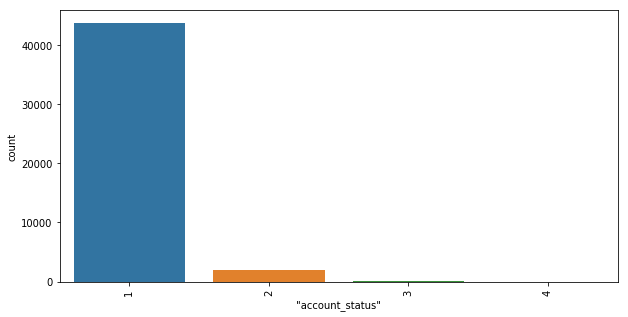

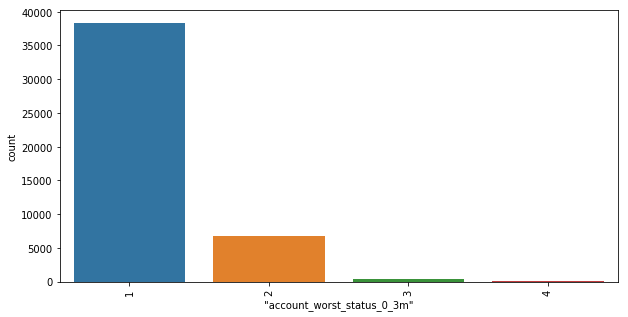

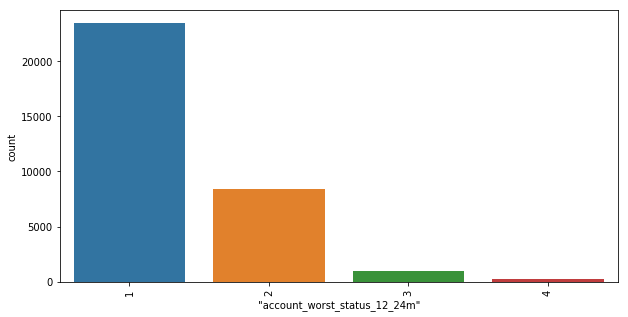

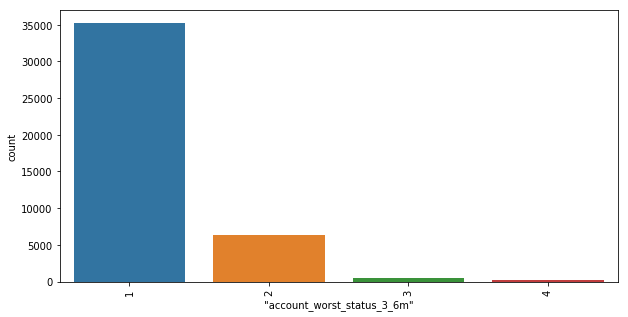

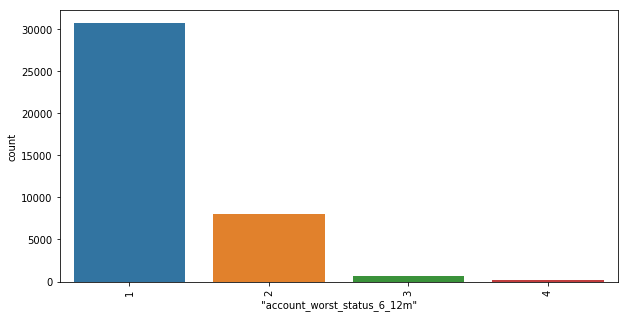

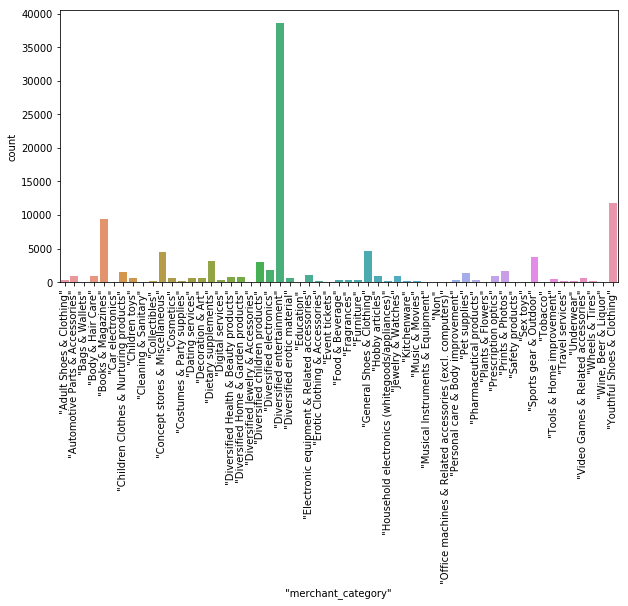

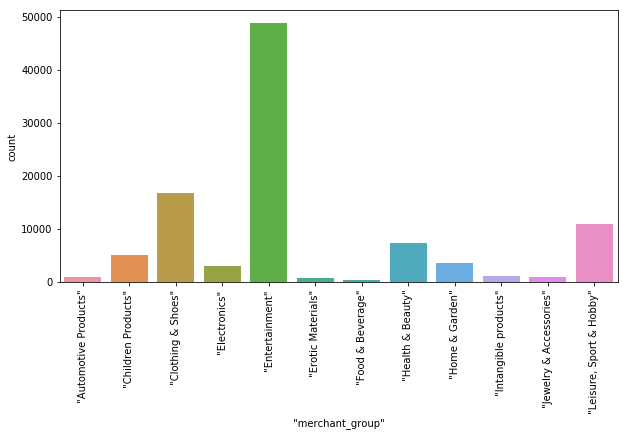

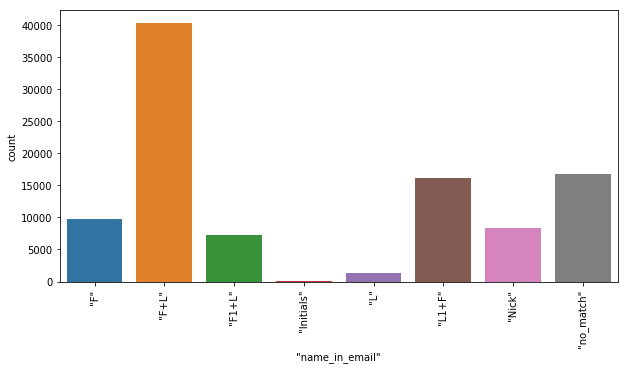

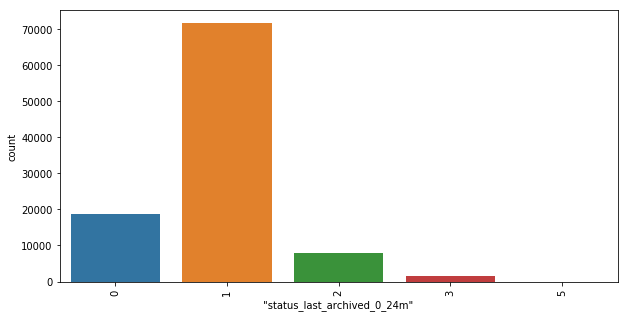

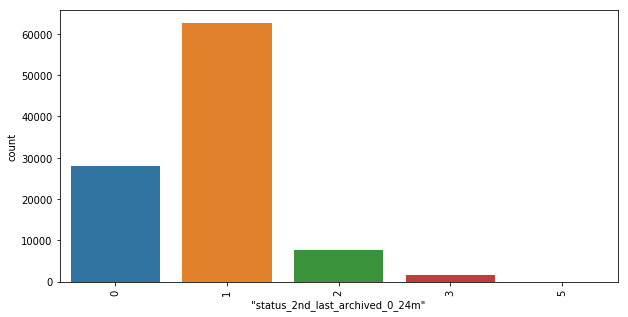

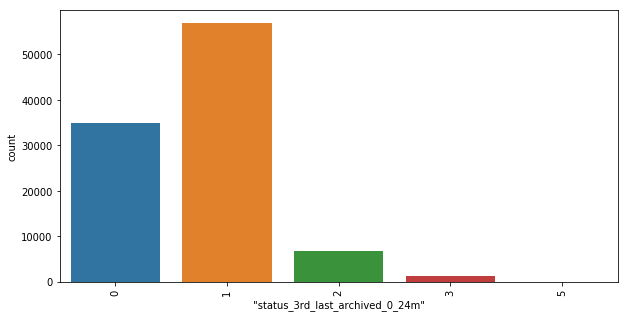

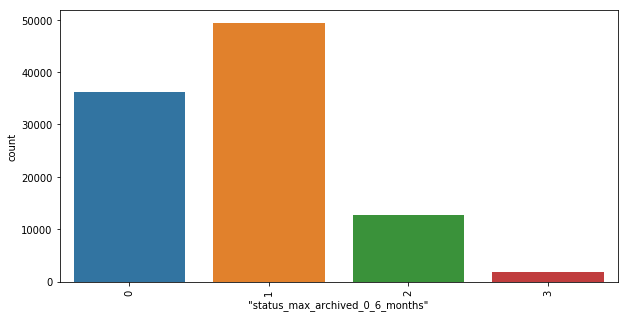

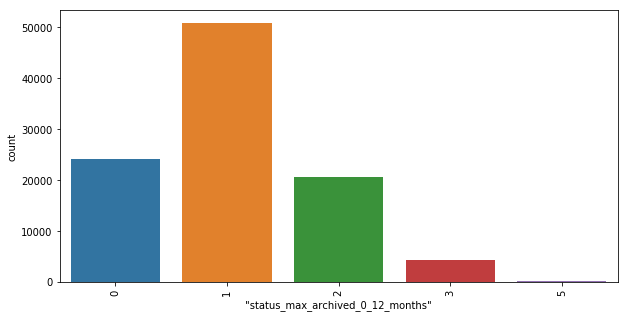

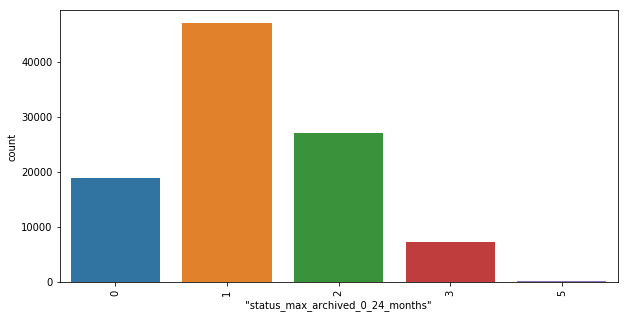

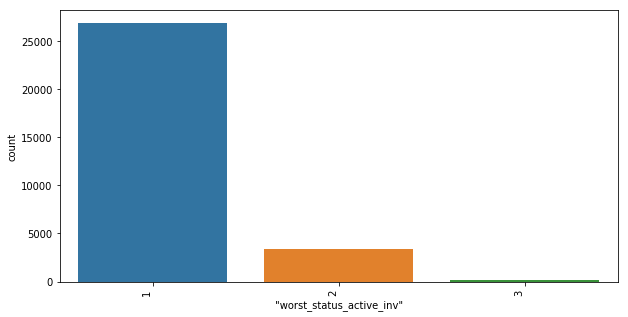

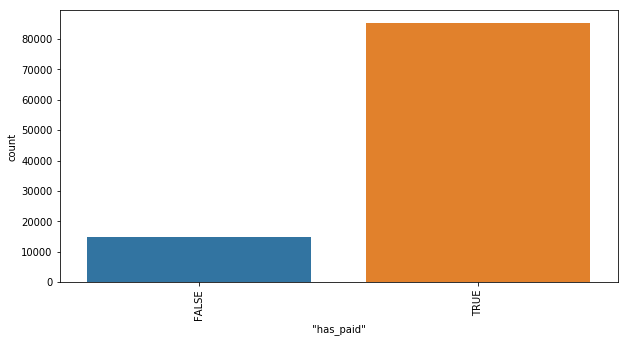

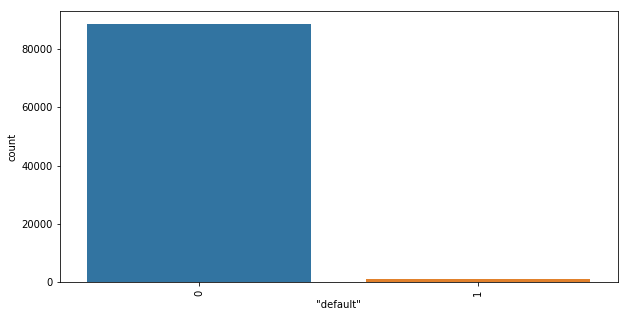

In [28]:
from matplotlib import pyplot as plt

for col in cat_columns:
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, data=df)
    plt.xticks(rotation='vertical')
    plt.show()

We could see from the plots, the dataset is imbalanced, i.e., we have much more 0 class than 1 class. Therefore we should use ROC curve and AUC score to evaluate the model.

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [29]:
df.corr()

,"""account_amount_added_12_24m""","""account_days_in_dc_12_24m""","""account_days_in_rem_12_24m""","""account_days_in_term_12_24m""","""account_incoming_debt_vs_paid_0_24m""","""age""","""avg_payment_span_0_12m""","""avg_payment_span_0_3m""","""max_paid_inv_0_12m""","""max_paid_inv_0_24m""",...,"""time_hours""","""account_days_in_dc_12_24m""_na","""account_days_in_rem_12_24m""_na","""account_days_in_term_12_24m""_na","""account_incoming_debt_vs_paid_0_24m""_na","""avg_payment_span_0_12m""_na","""avg_payment_span_0_3m""_na","""num_active_div_by_paid_inv_0_12m""_na","""num_arch_written_off_0_12m""_na","""num_arch_written_off_12_24m""_na"
"""account_amount_added_12_24m""",1.000000,0.004659,0.181844,0.038931,-0.002868,-0.033092,0.101297,0.080953,0.081407,0.097912,...,-0.001298,-0.126571,-0.126571,-0.126571,-0.414258,-0.131483,-0.110474,-0.131776,-0.141265,-0.141265
"""account_days_in_dc_12_24m""",0.004659,1.000000,0.072746,0.318924,-0.000316,-0.016877,0.037974,0.010800,-0.011025,-0.010057,...,-0.001395,-0.013212,-0.013212,-0.013212,-0.042467,0.009912,0.016598,0.006496,0.000525,0.000525
"""account_days_in_rem_12_24m""",0.181844,0.072746,1.000000,0.354173,-0.000809,-0.053432,0.196544,0.084878,-0.004029,0.005454,...,0.003137,-0.075698,-0.075698,-0.075698,-0.240334,-0.039205,0.008123,-0.046100,-0.069790,-0.069790
"""account_days_in_term_12_24m""",0.038931,0.318924,0.354173,1.000000,-0.000953,-0.031813,0.126595,0.047219,-0.008764,-0.005892,...,-0.001451,-0.033673,-0.033673,-0.033673,-0.110495,-0.003342,0.015309,-0.009463,-0.025469,-0.025469
"""account_incoming_debt_vs_paid_0_24m""",-0.002868,-0.000316,-0.000809,-0.000953,1.000000,-0.008650,0.000784,0.003672,0.001252,0.000985,...,-0.000872,-0.010400,-0.010400,-0.010400,-0.034278,-0.010387,-0.010066,-0.010152,-0.010488,-0.010488
"""age""",-0.033092,-0.016877,-0.053432,-0.031813,-0.008650,1.000000,-0.049250,-0.025520,-0.046753,-0.041692,...,0.001657,-0.043274,-0.043274,-0.043274,0.121745,0.116168,0.060776,0.118788,0.133590,0.133590
"""avg_payment_span_0_12m""",0.101297,0.037974,0.196544,0.126595,0.000784,-0.049250,1.000000,0.420931,0.006648,0.003998,...,-0.001272,-0.008203,-0.008203,-0.008203,-0.198172,-0.116471,0.091426,-0.113543,-0.098656,-0.098656
"""avg_payment_span_0_3m""",0.080953,0.010800,0.084878,0.047219,0.003672,-0.025520,0.420931,1.000000,0.026787,0.022624,...,-0.000458,0.007160,0.007160,0.007160,-0.128954,-0.076271,-0.134468,-0.074440,-0.064947,-0.064947
"""max_paid_inv_0_12m""",0.081407,-0.011025,-0.004029,-0.008764,0.001252,-0.046753,0.006648,0.026787,1.000000,0.885940,...,-0.002948,0.010808,0.010808,0.010808,-0.116236,-0.360953,-0.310549,-0.361612,-0.315567,-0.315567
"""max_paid_inv_0_24m""",0.097912,-0.010057,0.005454,-0.005892,0.000985,-0.041692,0.003998,0.022624,0.885940,1.000000,...,-0.001946,-0.005006,-0.005006,-0.005006,-0.136524,-0.339006,-0.286964,-0.340233,-0.338713,-0.338713


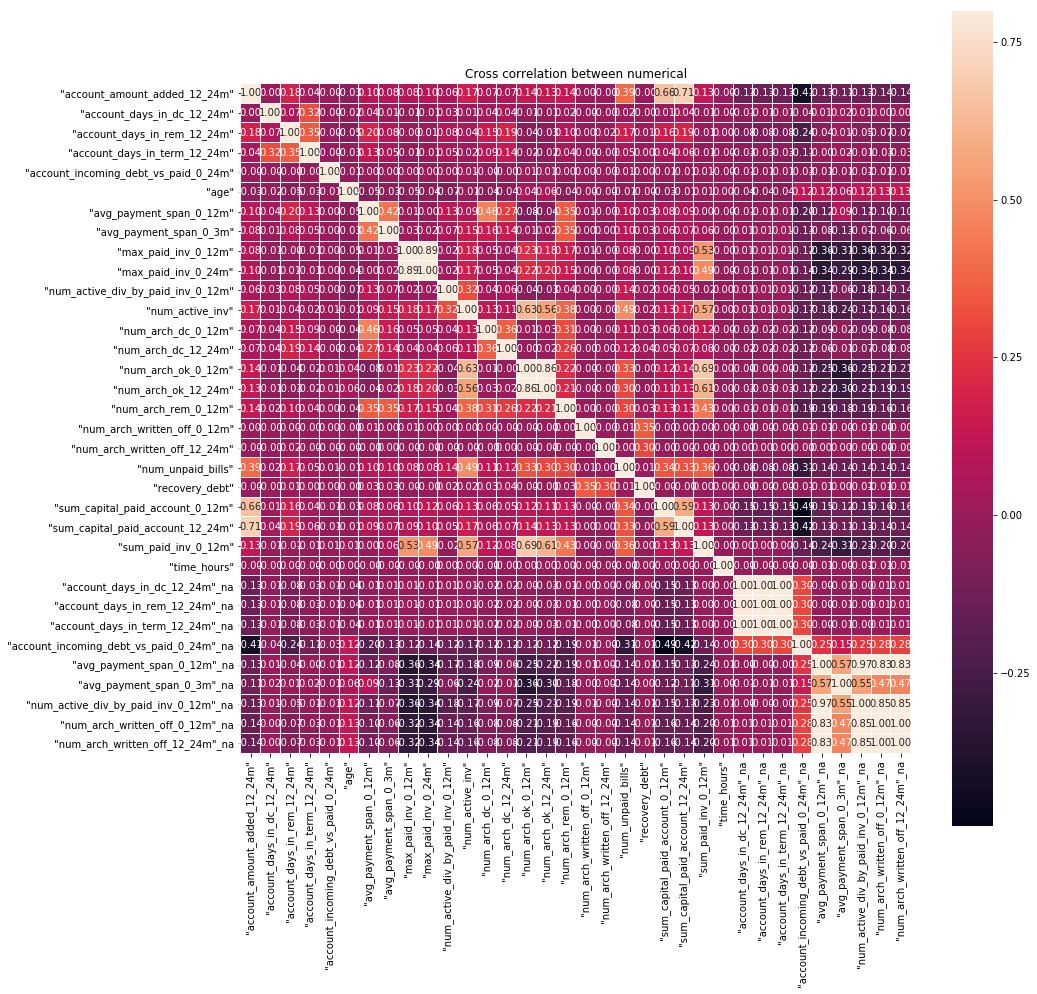

In [30]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df.corr(), vmax=.8, square=True, fmt='.2f', annot=True, linecolor='white', linewidths=0.01)
plt.title('Cross correlation between numerical')
plt.show()

It shows that the following features are highly correlated
- max_padi_inv_0_12m and max_padi_inv_0_24m 
- num_arch_ok_0_12m and num_arch_ok_12_24m
- account_days_in_dc_12_24m_na, account_days_in_term_12_24m_na, and account_days_in_rem_12_24m_na
- num_active_div_by_0_12m_na, num_arch_written_off_0_12m_na, and num_arch_written_off_12_24m_na

In [31]:
# remove the highly correlated columns
df_uncor = df.drop(['"max_paid_inv_0_24m"', '"num_arch_ok_12_24m"', 
                    '"account_days_in_rem_12_24m"_na', '"account_days_in_term_12_24m"_na', 
                    '"num_arch_written_off_0_12m"_na', '"num_arch_written_off_12_24m"_na'], axis=1)
df_uncor.head()

,"""account_amount_added_12_24m""","""account_days_in_dc_12_24m""","""account_days_in_rem_12_24m""","""account_days_in_term_12_24m""","""account_incoming_debt_vs_paid_0_24m""","""account_status""","""account_worst_status_0_3m""","""account_worst_status_12_24m""","""account_worst_status_3_6m""","""account_worst_status_6_12m""",...,"""sum_capital_paid_account_12_24m""","""sum_paid_inv_0_12m""","""time_hours""","""uuid""","""worst_status_active_inv""","""account_days_in_dc_12_24m""_na","""account_incoming_debt_vs_paid_0_24m""_na","""avg_payment_span_0_12m""_na","""avg_payment_span_0_3m""_na","""num_active_div_by_paid_inv_0_12m""_na"
0,0,0.0,0.0,0.0,0.000000,1,1,NaN,1,NaN,...,0,178839,9.653333,"""63f69b2c-8b1c-4740-b78d-52ed9a4515ac""",1\n,False,False,False,False,False
1,0,0.0,0.0,0.0,0.152082,1,1,1,1,1,...,0,49014,13.181389,"""0e961183-8c15-4470-9a5e-07a1bd207661""",NaN,False,True,False,False,False
2,0,0.0,0.0,0.0,0.152082,NaN,NaN,NaN,NaN,NaN,...,0,124839,11.561944,"""d8edaae6-4368-44e0-941e-8328f203e64e""",1\n,False,True,False,False,False
3,0,0.0,0.0,0.0,0.152082,NaN,NaN,NaN,NaN,NaN,...,0,324676,15.751111,"""0095dfb6-a886-4e2a-b056-15ef45fdb0ef""",1\n,True,True,False,False,False
4,0,0.0,0.0,0.0,0.152082,NaN,NaN,NaN,NaN,NaN,...,0,7100,12.698611,"""c8f8b835-5647-4506-bf15-49105d8af30b""",NaN,False,True,False,False,False


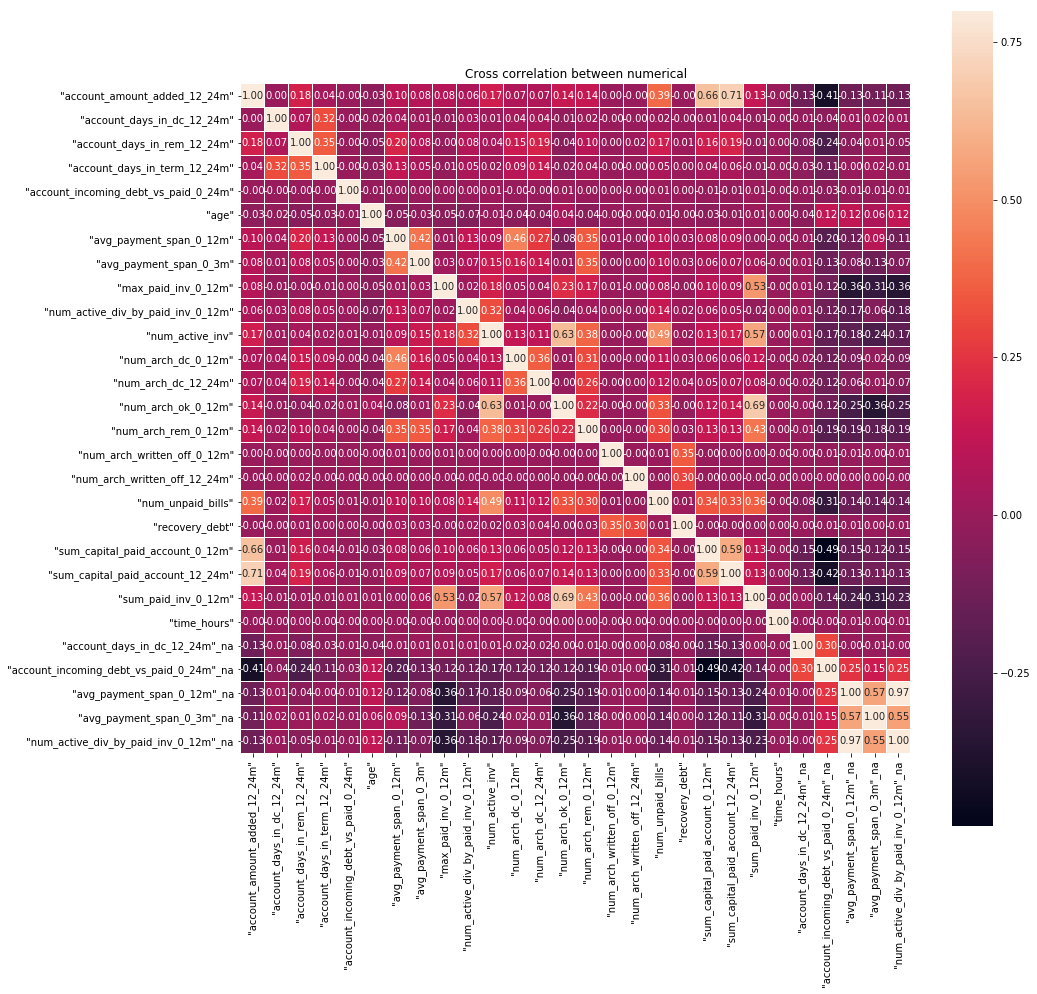

In [32]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df_uncor.corr(), vmax=.8, square=True, fmt='.2f', annot=True, linecolor='white', linewidths=0.01)
plt.title('Cross correlation between numerical')
plt.show()

In [33]:
print(df_uncor.shape)

(99976, 46)


In [34]:
df_uncor.describe()

,"""account_amount_added_12_24m""","""account_days_in_dc_12_24m""","""account_days_in_rem_12_24m""","""account_days_in_term_12_24m""","""account_incoming_debt_vs_paid_0_24m""","""age""","""avg_payment_span_0_12m""","""avg_payment_span_0_3m""","""max_paid_inv_0_12m""","""num_active_div_by_paid_inv_0_12m""",...,"""num_arch_ok_0_12m""","""num_arch_rem_0_12m""","""num_arch_written_off_0_12m""","""num_arch_written_off_12_24m""","""num_unpaid_bills""","""recovery_debt""","""sum_capital_paid_account_0_12m""","""sum_capital_paid_account_12_24m""","""sum_paid_inv_0_12m""","""time_hours"""
count,9.997600e+04,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,...,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,99976.000000,9.997600e+04,99976.000000
mean,1.225515e+04,0.196637,4.447397,0.252931,0.631676,36.016284,17.241348,14.008486,9203.654217,0.088491,...,7.275826,0.469443,0.000100,0.000130,2.141564,4.035429,10816.065386,6542.895325,3.920880e+04,15.329780
std,3.548148e+04,5.453955,21.529696,2.752574,16.898532,13.001306,11.203926,7.398105,13512.167229,0.262109,...,16.030369,1.360349,0.010001,0.013039,6.300978,163.934564,26463.972170,19041.223585,9.064929e+04,5.031360
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000278
25%,0.000000e+00,0.000000,0.000000,0.000000,0.152082,25.000000,12.200000,13.000000,2000.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.600000e+03,11.622708
50%,0.000000e+00,0.000000,0.000000,0.000000,0.152082,34.000000,14.909091,13.000000,6052.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.599500e+04,15.792778
75%,4.937250e+03,0.000000,0.000000,0.000000,0.152082,45.000000,18.595946,13.250000,11380.000000,0.050000,...,7.000000,0.000000,0.000000,0.000000,2.000000,0.000000,9029.750000,85.000000,4.384425e+04,19.542014
max,1.128775e+06,365.000000,365.000000,97.000000,3914.000000,100.000000,260.000000,87.000000,279000.000000,9.000000,...,261.000000,42.000000,1.000000,2.000000,182.000000,36479.000000,571475.000000,341859.000000,2.962870e+06,23.999722


In [35]:
#convert categorical features to integer 
for col in cat_columns:
    if col != '"default"':
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(df_uncor[col].tolist())
        df_uncor[col] = label_encoder.transform(df_uncor[col].tolist())

In [36]:
df_uncor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 46 columns):
"account_amount_added_12_24m"               99976 non-null int64
"account_days_in_dc_12_24m"                 99976 non-null float64
"account_days_in_rem_12_24m"                99976 non-null float64
"account_days_in_term_12_24m"               99976 non-null float64
"account_incoming_debt_vs_paid_0_24m"       99976 non-null float64
"account_status"                            99976 non-null int64
"account_worst_status_0_3m"                 99976 non-null int64
"account_worst_status_12_24m"               99976 non-null int64
"account_worst_status_3_6m"                 99976 non-null int64
"account_worst_status_6_12m"                99976 non-null int64
"age"                                       99976 non-null int64
"avg_payment_span_0_12m"                    99976 non-null float64
"avg_payment_span_0_3m"                     99976 non-null float64
"default"                         

## 3. Prediction

In [37]:
df_uncor['"default"'].isnull().sum()

10000

In [38]:
df_uncor['"default"'].value_counts()

0    88688
1     1288
Name: "default", dtype: int64

In [39]:
df_uncor['"default"'].unique()

[0, 1, NaN]
Categories (2, object): [0 < 1]

In [40]:
df_uncor.shape

(99976, 46)

In [41]:
df_uncor_train = df_uncor[df_uncor['"default"'].notnull()]

In [42]:
df_uncor_train.shape

(89976, 46)

In [43]:
df_uncor_test = df_uncor[df_uncor['"default"'].isnull()]

In [44]:
df_uncor_test.shape

(10000, 46)

In [45]:
# prepare dataset
X_train = df_uncor_train.drop(['"default"', '"uuid"'], axis=1)
y_train = df_uncor_train['"default"'].astype('category')

X_test = df_uncor_test.drop(['"default"', '"uuid"'], axis=1)
#y_test = df_uncor_test['"default"'].astype('category')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [46]:
df_uncor_train['"default"'].value_counts()

0    88688
1     1288
Name: "default", dtype: int64

- Random Forest

In [47]:
# train a randomforest classifier
clf = RandomForestClassifier(n_jobs=2)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
train_score = clf.score(X_train, y_train)

print('train score: {}'.format(round(train_score, 3)))

train score: 0.997


In [49]:
pred = clf.predict(X_train)
#fpr, tpr, thresholds = metrics.roc_curve(y_train, pred, pos_label=2)

In [50]:
y_predict_probabilities = clf.predict_proba(X_train)[:,1]

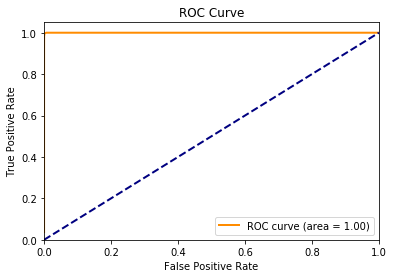

In [51]:
# http://benalexkeen.com/scoring-classifier-models-using-scikit-learn/
fpr, tpr, _ = roc_curve(list(map(int, y_train.tolist())), y_predict_probabilities)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [52]:
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_roc_crossval.html
def show_roc_curves(X, y, clf = RandomForestClassifier(n_jobs=2), n_splits = 3, colors = cycle(['yellow', 'blue', 'darkorange'])):
    '''
    Run classifier with cross-validation and plot ROC curves
    '''
    cv = StratifiedKFold(n_splits=n_splits)
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    #colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    #colors = cycle(['yellow', 'blue', 'darkorange'])
    
    lw = 2
    i = 0
    
    #X = X_train.values
    #y = y_train.values
    for (train, test), color in zip(cv.split(X, y), colors):
        clf.fit(X[train], y[train])
        probas_ = clf.predict_proba(X[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(list(map(int, y[test])), probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        
        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return mean_auc

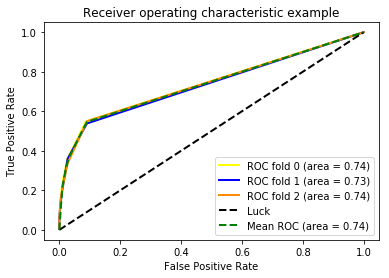

mean_auc: 0.7375290866614802


In [53]:
mean_auc = show_roc_curves(X_train.values, y_train.values, clf = RandomForestClassifier(n_jobs=2))
print('mean_auc: {}'.format(mean_auc))

In [54]:
np.array(y_train.apply(int))

array([0, 0, 0, ..., 0, 0, 0])

- Gradient Boost Machine

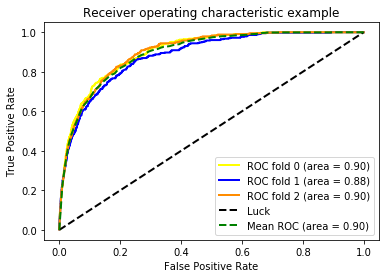

mean_auc: 0.8951455644863493


In [55]:
mean_auc = show_roc_curves(X_train.values, y_train.values, clf = XGBClassifier(n_jobs=2))
print('mean_auc: {}'.format(mean_auc))

The results show that xgboost outperforms random forest

In [58]:
# hyperparameter tuning
# reference: 
# https://machinelearningmastery.com/xgboost-python-mini-course/
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost/code
# https://xgboost-clone.readthedocs.io/en/latest/parameter.html

def predict_xgb(X_train, y_train, X_test, 
                params = {
                'n_estimators': [5, 50, 100, 200],
                'min_child_weight': [1, 5, 10],
                # 'gamma': [0.5, 1, 1.5, 2, 5],
                # 'subsample': [0.6, 0.8, 1.0],
                #'subsample': [0.6, 0.8, 1],
                # 'colsample_bytree': [0.6, 0.8, 1.0],
                # 'colsample_bytree': [0.6, 0.8, 1],
                # 'max_depth': [3, 4, 5]
                'max_depth': [2, 4, 6],}, 
                folds=5, param_comb=2, n_jobs=2):
    def timer(start_time=None):
        # fork from https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
        if not start_time:
            start_time = datetime.now()
            return start_time
        elif start_time:
            thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
            tmin, tsec = divmod(temp_sec, 60)
            print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


    xgb_clf = XGBClassifier(silent=True)

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    search = RandomizedSearchCV(xgb_clf, 
                                param_distributions=params, 
                                n_iter=param_comb, 
                                scoring='roc_auc', # binary classification
                                #scoring='accuracy',
                                #n_jobs=-1,
                                n_jobs=n_jobs,
                                cv=skf.split(X_train, y_train),
                                verbose=3, random_state=42)

    # search = GridSearchCV(model, params, scoring="neg_log_loss", n_jobs=-1, cv=skf)

    start_time = timer(None)
    search.fit(X_train, np.array(y_train.apply(int)))
    timer(start_time)

    print('--------------')
    print('\n all results:')
    print(search.cv_results_)

    print('\n best estimator:')
    print(search.best_estimator_)

    print('\n best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
    print(search.best_score_ * 2 - 1)

    print('\n best xgb hyperparameters:')
    print(search.best_params_)

    result_csv_path = 'xgb-search-results.csv'
    results = pd.DataFrame(search.cv_results_)
    results.to_csv(result_csv_path, index=False)
    print('save xgb search results to {}'.format(result_csv_path))

    model_path = 'xgb.pkl'
    joblib.dump(search.best_estimator_, model_path)
    #pickle.dump(search, open(model_path, "wb"))
    print('save xgb model to {}'.format(model_path))
    print('--------------')

    #search = joblib.load(model_path)
    y_pred = search.predict_proba(X_test)[:,1]
    
    return y_pred
    #y_pred = np.argmax(y_pred)

    #y_pred = search.predict(X_test)
    #predictions = [round(value) for value in y_pred]

    # evaluate predictions
    #accuracy = accuracy_score(y_test, predictions)
    #print('accuracy: {}'.format(round(accuracy, 3)))
    #conf_matrix = confusion_matrix(y_test, predictions)
    #print(conf_matrix)

    #print(classification_report(y_test, predictions))

In [59]:
y_pred = predict_xgb(X_train, y_train, X_test)
print(y_pred)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] n_estimators=200, min_child_weight=10, max_depth=6 ..............
[CV] n_estimators=200, min_child_weight=10, max_depth=6 ..............
[CV]  n_estimators=200, min_child_weight=10, max_depth=6, score=0.9188179190473568, total=  26.4s
[CV] n_estimators=200, min_child_weight=10, max_depth=6 ..............
[CV]  n_estimators=200, min_child_weight=10, max_depth=6, score=0.8951756663091806, total=  26.5s
[CV] n_estimators=200, min_child_weight=10, max_depth=6 ..............
[CV]  n_estimators=200, min_child_weight=10, max_depth=6, score=0.9094945507433346, total=  26.4s
[CV] n_estimators=200, min_child_weight=10, max_depth=6 ..............
[CV]  n_estimators=200, min_child_weight=10, max_depth=6, score=0.8994935513684709, total=  26.3s
[CV] n_estimators=50, min_child_weight=1, max_depth=4 ................
[CV]  n_estimators=50, min_child_weight=1, max_depth=4, score=0.9043968801705444, total=   4.7s
[CV] n_estimators=50, min_

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.4min finished



 Time taken: 0 hours 1 minutes and 56.52 seconds.
--------------

 all results:
{'mean_fit_time': array([26.15046821,  4.61167412]), 'std_fit_time': array([0.11736238, 0.01296653]), 'mean_score_time': array([0.21412859, 0.06787672]), 'std_score_time': array([0.00418728, 0.00125524]), 'param_n_estimators': masked_array(data=[200, 50],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10, 1],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[6, 4],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 6}, {'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 4}], 'split0_test_score': array([0.91881792, 0.90439688]), 'split1_test_score': array([0.89517567, 0.87773359]), 'split2_test_score': array([0.90949455, 0.90127587]), 'split3_test_sc

#### Save prediction

In [60]:
df_pred = df_uncor_test[['"uuid"']]

In [61]:
df_pred['"pd"'] = y_pred

In [62]:
df_pred

,"""uuid""","""pd"""
89976,"""6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7""",0.001182
89977,"""f6f6d9f3-ef2b-4329-a388-c6a687f27e70""",0.003378
89978,"""e9c39869-1bc5-4375-b627-a2df70b445ea""",0.001410
89979,"""6beb88a3-9641-4381-beb6-c9a208664dd0""",0.009779
89980,"""bb89b735-72fe-42a4-ba06-d63be0f4ca36""",0.012667
89981,"""e4eede99-76a3-4437-a540-3059a1eff67c""",0.012368
89982,"""a2af8d9e-9f81-4185-8fff-b2ec49d681a6""",0.000145
89983,"""ec910486-1e66-402a-80f2-08c6f04a9a1b""",0.005719
89984,"""08973cf0-646a-4fa7-9f1f-d03f76ffd59c""",0.000922
89985,"""0591fb4e-5b48-4bac-bce7-f2d5d141e976""",0.000383


In [63]:
df_pred.to_csv('prediction.csv', index=False)